In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [3]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from colabgymrender.recorder import Recorder

In [5]:
env = gym.make('CartPole-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


41.0


 98%|█████████▊| 42/43 [00:00<00:00, 284.18it/s]


In [6]:
total_reward

41.0

In [7]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 50000
epsilon_decay_intervals = 10000
gamma = 0.99 # discount
alpha = 5e-4 # learning rate

memory_size = 50000
min_replay_size = 1000
batch_size = 32

target_update_frequency = 1000 # target network update frequency

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()
    
        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            #nn.ReLU(),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n)
        )
    
    def forward(self, state):
        return self.network(state)
    
    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [9]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()
    
    return memory

In [10]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)
        
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0

        
        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net 

In [11]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

Episode: 48 Step: 1000 Average reward: 20.604166666666668
Episode: 96 Step: 2000 Average reward: 20.6875
Episode: 138 Step: 3000 Average reward: 22.37
Episode: 173 Step: 4000 Average reward: 24.78
Episode: 201 Step: 5000 Average reward: 29.15
Episode: 227 Step: 6000 Average reward: 32.02
Episode: 246 Step: 7000 Average reward: 38.0
Episode: 261 Step: 8000 Average reward: 42.7
Episode: 275 Step: 9000 Average reward: 49.57
Episode: 284 Step: 10000 Average reward: 55.6
Episode: 291 Step: 11000 Average reward: 62.14
Episode: 299 Step: 12000 Average reward: 70.11
Episode: 304 Step: 13000 Average reward: 77.6
Episode: 310 Step: 14000 Average reward: 86.77
Episode: 315 Step: 15000 Average reward: 93.98
Episode: 320 Step: 16000 Average reward: 101.96
Episode: 325 Step: 17000 Average reward: 109.51
Episode: 330 Step: 18000 Average reward: 117.07
Episode: 335 Step: 19000 Average reward: 125.05
Episode: 340 Step: 20000 Average reward: 132.32
Episode: 345 Step: 21000 Average reward: 139.16
Episode

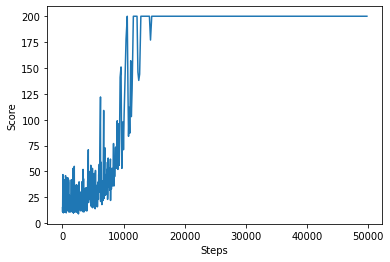

In [ ]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [ ]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

200.0


100%|█████████▉| 201/202 [00:00<00:00, 278.53it/s]


**Trần văn lực - 20521587**

### **Training model, changing neural network architectur** and **hyperparameter tuning** 🚓 💪 📈

In [27]:
# changing neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()
    
        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 24),
            nn.Tanh(),
            nn.Linear(24, 48),
            nn.Tanh(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, env.action_space.n),
        )
    
    def forward(self, state):
        return self.network(state)
    
    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

# Hyperparameters cho MountainCar-v0 
#=======================================================
# Changes : alpha = 0.001
#          epsilon_decay_intervals = 1000
#          memory_size = 200000 
#          target_update_frequency = 100
#=======================================================
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 50000
epsilon_decay_intervals = 1000  # old = 10000
gamma = 0.99 # discount
alpha = 0.001 # learning rate   # old = 5e-4

memory_size = 200000            # old = 50000
min_replay_size = 1000          
batch_size = 32

target_update_frequency = 100 # target network update frequency # old = 1000
# make env
env = gym.make('MountainCar-v0')

# training model
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

Episode: 5 Step: 1000 Average reward: -200.0
Episode: 10 Step: 2000 Average reward: -200.0
Episode: 15 Step: 3000 Average reward: -200.0
Episode: 20 Step: 4000 Average reward: -200.0
Episode: 25 Step: 5000 Average reward: -199.68
Episode: 30 Step: 6000 Average reward: -197.5
Episode: 35 Step: 7000 Average reward: -197.85714285714286
Episode: 40 Step: 8000 Average reward: -198.125
Episode: 45 Step: 9000 Average reward: -196.13333333333333
Episode: 50 Step: 10000 Average reward: -196.52
Episode: 55 Step: 11000 Average reward: -196.56363636363636
Episode: 61 Step: 12000 Average reward: -195.8360655737705
Episode: 66 Step: 13000 Average reward: -194.46969696969697
Episode: 71 Step: 14000 Average reward: -194.69014084507043
Episode: 76 Step: 15000 Average reward: -195.03947368421052
Episode: 83 Step: 16000 Average reward: -192.50602409638554
Episode: 88 Step: 17000 Average reward: -192.6818181818182
Episode: 93 Step: 18000 Average reward: -193.0752688172043
Episode: 99 Step: 19000 Average r

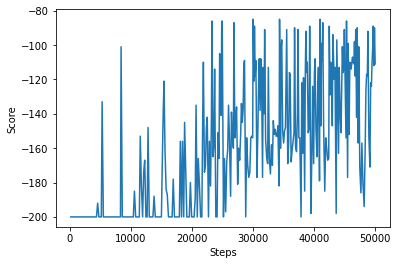

In [28]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [29]:
env = gym.make('MountainCar-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

-86.0


 99%|█████████▉| 87/88 [00:00<00:00, 315.90it/s]
